In [560]:
import os
import csv
import sys
import copy
import time
import logging
import datetime
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [561]:
def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def remove_outliers(X, threshold=7):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))


In [562]:
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
batch_size = 120

#XR, yR = make_regression(n_samples=1000, n_features=2, n_informative=5, noise=50, random_state=5)
#X_train, X_test, y_train, y_test = train_test_split(XR, yR, test_size=0.20, random_state=2)
#columns = ["{0}".format(total_columns[i]) for i in range(XR.shape[1]+1)]
#dataframe = pd.DataFrame(np.concatenate([XR, np.reshape(yR, [-1, 1])], axis=1), columns=columns)

stocks = pd.read_csv("../data/datasets/all_stocks_5yr.csv")
stocks = pd.DataFrame(stocks)
filter = stocks["Name"]=="AAPL"
stocks = stocks.where(filter).dropna()
stocks.drop(['Name', "date"], axis=1, inplace=True)
stocks['target'] = stocks['open'].fillna(stocks['open'].mean())-stocks['close'].fillna(stocks['close'].mean())
#data['type'] = 1 if dataframe['open']-dataframe['close']>=0 else 0
rnnstocks = stocks.values[0:100, :]
n_features = len(rnnstocks[0])
n_rows = 10
n_ciclics = 10
data = np.array(rnnstocks).reshape(n_ciclics, n_rows, n_features)
X = data[:, 0:-1, :]
Y = data[:, -1, :]

stocks.head()

,open,high,low,close,volume,target
1259,67.7142,68.4014,66.8928,67.8542,158168416.0,-0.1400
1260,68.0714,69.2771,67.6071,68.5614,129029425.0,-0.4900
1261,68.5014,68.9114,66.8205,66.8428,151829363.0,1.6586
1262,66.7442,67.6628,66.1742,66.7156,118721995.0,0.0286
1263,66.3599,67.3771,66.2885,66.6556,88809154.0,-0.2957


In [563]:
vif_data = pd.DataFrame()
vif_data["features"] = stocks.columns
vif_data["VIF"] = [variance_inflation_factor(stocks.values, i) for i in range(len(stocks.columns))]
print(vif_data)

  features           VIF
0     open           inf
1     high  5.060050e+04
2      low  4.511802e+04
3    close           inf
4   volume  2.630125e+00
5   target           inf


C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [564]:
class DenseLayer(tf.Module):
    def __init__(self, n_neurons, input_dim, n_features):
        self.n_neurons = n_neurons
        self.input_dim = input_dim
        self.n_features = n_features
        self.builded = False
    
    @tf.function
    def build(self):
        if not self.builded:
            self.W_n = tf.Variable(tf.random.uniform(shape=(self.n_neurons, self.input_dim, self.n_features)), dtype=tf.float32, trainable=True)
            self.bias = tf.Variable(tf.ones(shape=(self.input_dim, self.n_features)), dtype=tf.float32, trainable=True)
            self.vars = [self.W_n, self.bias]
            self.builded = True
            
    @tf.function(reduce_retracing=True)
    def __call__(self, X):
        print("------DenseLayer------")
        updated_input = tf.nn.relu(tf.add(tf.multiply(self.W_n, X), self.bias))
        output = tf.reduce_mean(updated_input, axis=0)
        
        print("[#] updated_input: {0}, output: {1}".format(updated_input.shape, output.shape))
        print("\n")
        return output, self.bias
    
class LSTMLayer(tf.Module):
    def __init__(self, units, input_dim, output_dim):
        self.units = units
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.builded = False   

    
    @tf.function
    def build(self):
        if not self.builded:
            #Initialize weights matrices
            self.W_xh = tf.Variable(tf.eye(self.units, self.input_dim), trainable=True, dtype=tf.float32)
            self.W_hh = tf.Variable(tf.eye(self.units, self.units), trainable=True, dtype=tf.float32)
            self.W_hy = tf.Variable(tf.eye(self.output_dim, self.units), trainable=True, dtype=tf.float32)
            #Initialize hidden state (Memory)
            self.h = tf.Variable(tf.zeros([self.units, 1]), dtype=tf.float32)
            self.vars = [self.W_xh, self.W_hh, self.W_hy]
            self.builded = True

    @tf.function(reduce_retracing=True)
    def __call__(self, x):
        print("------LSTMLayer------")
        print("[#] W_xh: {0}, W_hh: {1}, W_hy: {2}".format(self.W_xh.shape, self.W_hh.shape, self.W_hy.shape))
        updated_input = tf.multiply(self.W_xh, x)
        updated_memory = tf.multiply(self.W_hh, self.h)
        print("[#] updated_input: {0}, updated_memory: {1}".format(updated_input.shape, updated_memory.shape))
        self.h = tf.nn.tanh(
            tf.add(updated_memory, updated_input), 
        )
        output = tf.reduce_mean(tf.nn.sigmoid(tf.multiply(self.W_hy, self.h)), axis=1)
        print("[#] h: {0}, output: {1}".format(self.h.shape, output.shape))
        print("\n")
        return output, self.h

In [565]:
class MarketAI(tf.Module):
    def __init__(self, layers, epochs=100, lr=0.1):
        self.epochs = epochs+1
        self.layers = layers
        self.Adam = tf.optimizers.Adam(lr)
        self.loss_history = [e for e in range(self.epochs)]
        self.r2_history = [e for e in range(self.epochs)]
        self.losses = [e for e in range(len(self.layers))]

    def _history(self, e, loss, y, y_pred):
        self.loss_history[e] = loss
        self.r2_history[e] = self.r2(y, y_pred)

    def build(self):
        self.layers[0].build()
        self.layers[1].build()
        self.layers[2].build()
        
    def r2(self, y, y_pred):
        return tf.reduce_mean(tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float32), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        ))
    
    def _apply_gradients(self, tape):
        for l in range(len(self.layers)):
            grads = tape.gradient(self.losses[l], self.layers[l].vars) 
            self.Adam.apply_gradients(zip(grads, self.layers[l].vars))

    @tf.function(reduce_retracing=True)
    def loss(self, y, predicted):
        return tf.losses.MSE(y, predicted)    

    @tf.function
    def _train_lstm(self, i, X_train, X_train_norm):
        losses = 0.01
        for x in X_train_norm:
            output, h = self.layers[i](x)
            losses = losses + self.loss(x, output)
        loss = losses / len(X_train_norm)
        return loss, output, h

    @tf.function
    def _train_dense(self, i, X_train, X_train_norm):
        output, bias = self.layers[i](X_train_norm)
        predicted = tf.add(tf.multiply(X_train, output), bias)
        losses = self.loss(X_train, predicted)
        loss = tf.reduce_sum(losses)
        return loss, predicted

    def train(self, X_train):
        X_train_norm = tf.convert_to_tensor(normalize_dataset(X_train), dtype=tf.float32)
        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        
        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.losses[0], output = self._train_dense(0, X_train, X_train_norm)
                self.losses[1], output, h = self._train_lstm(1, X_train, output)
                self.losses[2], self.predicted = self._train_dense(2, X_train, output)
            self._apply_gradients(tape)

            self._history(e, self.losses[2], X_train, self.predicted)
            if e%50==0 or e == 0:
                print("[-] Loss: {0}, Loss: {1}, Loss: {2}, R2: {3}".format(self.losses[0], self.losses[1], self.losses[2], self.r2_history[e]))

In [566]:
n_ciclic, n_rows, n_features = X.shape
n_neurons = 2
epochs = 200
lr = 0.01
model = MarketAI([
    DenseLayer(n_neurons, n_rows, n_features),
    LSTMLayer(1, n_features, n_features),
    DenseLayer(n_neurons, n_rows, n_features),
], epochs, lr)
model.build()
model.train(X[0])

------DenseLayer------
[#] updated_input: (2, 9, 6), output: (9, 6)


------LSTMLayer------
[#] W_xh: (1, 6), W_hh: (1, 1), W_hy: (6, 1)
[#] updated_input: (1, 6), updated_memory: (1, 1)
[#] h: (1, 6), output: (6,)


------DenseLayer------
[#] updated_input: (2, 9, 6), output: (9, 6)


[-] Loss: 7700296004272128.0, Loss: 6171575946575872.0, Loss: 1873746054873088.0, R2: 0.9018237590789795
[-] Loss: 50171287175168.0, Loss: 2304615831830528.0, Loss: 6209678606336.0, R2: 0.9996702075004578
[-] Loss: 235773214720.0, Loss: 2491089621614592.0, Loss: 99137118208.0, R2: 0.9999947547912598
[-] Loss: 1653963648.0, Loss: 2495057366089728.0, Loss: 8163662336.0, R2: 0.9999995827674866
[-] Loss: 3796096.25, Loss: 2494926101151744.0, Loss: 1603170304.0, R2: 0.9999999403953552


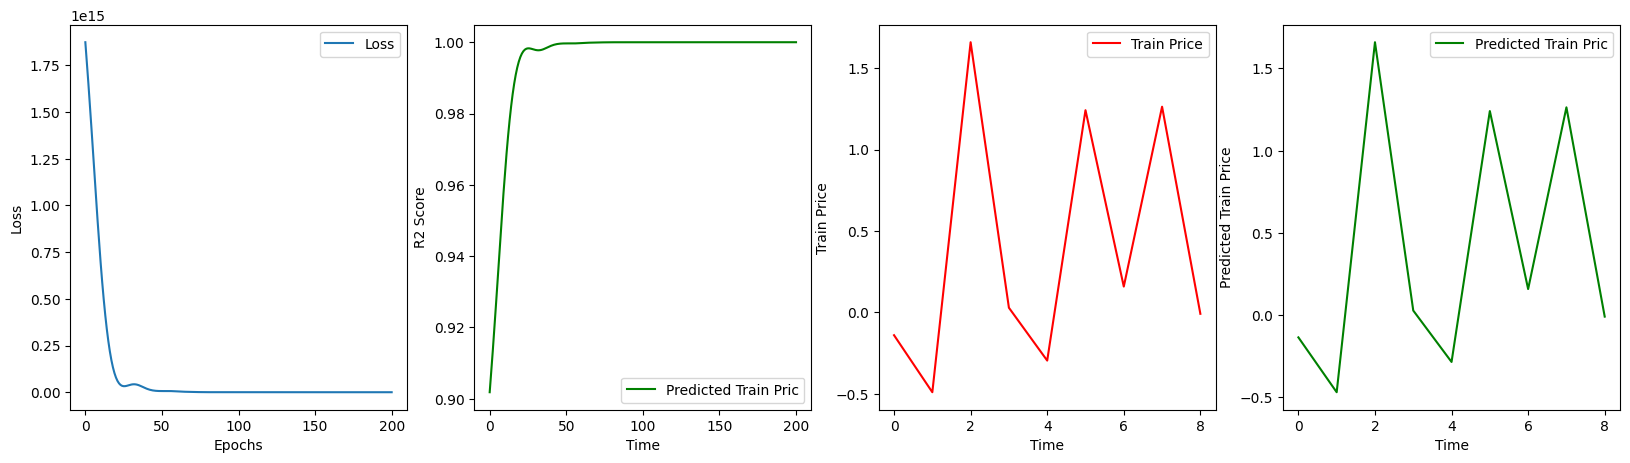

In [567]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].plot([e for e in range(len(model.loss_history))], model.loss_history, label="Loss")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[2].plot([e for e in range(len(X[0, :, :]))], X[0, :, -1], label="Train Price", color='red')
ax[2].set_ylabel('Train Price')
ax[2].set_xlabel('Time')
ax[2].legend()
ax[3].plot([e for e in range(len(X[0, :, :]))], model.predicted[:, -1], label="Predicted Train Pric", color='green')
ax[3].set_ylabel('Predicted Train Price')
ax[3].set_xlabel('Time')
ax[3].legend()

ax[1].plot([e for e in range(len(model.r2_history))], model.r2_history, label="Predicted Train Pric", color='green')
ax[1].set_ylabel('R2 Score')
ax[1].set_xlabel('Time')
ax[1].legend()